#  Продуктовые метрики, работа с логами

Анализ [логов покупок онлайн-магазина, продающего атрибутику компании Google.](https://www.kaggle.com/c/ga-customer-revenue-prediction/data?select=train.csv)

__Цели:__ 

- Построить несколько пользовательских метрик: посещаемость, средняя выручка, возвращаемость
- Проанализровать как ведут себя пользовательские метрики в разбивке по разным источникам (браузеры, устройства и тп)
- Сделать исходя из этого анализа несколько маркетинговых выводов

In [1]:
import numpy as np         # библиотека для матриц и математики
import pandas as pd        # библиотека для работы с табличками
from scipy import stats    # модуль для работы со статистикой

import matplotlib.pyplot as plt
import seaborn as sns

# стиль графиков
# plt.style.use('ggplot')    
plt.style.use('fivethirtyeight')
%matplotlib inline

# 1. Данные

> Познакомимся с логом, с которым мы будем работать. Приведём его в удобный для строительства метрик вид. 

In [2]:
df = pd.read_csv('google_log.csv', sep='\t')

df['totals.transactionRevenue'] = df['totals.transactionRevenue']/10**6

print(df.shape)
df.head()

/Users/annanityuk/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(903653, 24)


,date,fullVisitorId,sessionId,channelGrouping,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.subContinent,...,totals.pageviews,totals.transactionRevenue,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent
0,20160902,1131660440785968503,1131660440785968503_1472830385,Organic Search,1472830385,Chrome,Windows,False,desktop,Western Asia,...,1.0,NaN,google,organic,(not provided),NaN,NaN,NaN,NaN,NaN
1,20160902,377306020877927890,377306020877927890_1472880147,Organic Search,1472880147,Firefox,Macintosh,False,desktop,Australasia,...,1.0,NaN,google,organic,(not provided),NaN,NaN,NaN,NaN,NaN
2,20160902,3895546263509774583,3895546263509774583_1472865386,Organic Search,1472865386,Chrome,Windows,False,desktop,Southern Europe,...,1.0,NaN,google,organic,(not provided),NaN,NaN,NaN,NaN,NaN
3,20160902,4763447161404445595,4763447161404445595_1472881213,Organic Search,1472881213,UC Browser,Linux,False,desktop,Southeast Asia,...,1.0,NaN,google,organic,google + online,NaN,NaN,NaN,NaN,NaN
4,20160902,27294437909732085,27294437909732085_1472822600,Organic Search,1472822600,Chrome,Android,True,mobile,Northern Europe,...,1.0,NaN,google,organic,(not provided),NaN,NaN,NaN,NaN,NaN


__Описание колонок:__ 


- `date` дата посещения сайта (рассматривается период с 20160801 по 20170801
- `fullVisitorId` уникальный id пользователя
- `sessionId` уникальный id одной пользовательской сессии
- `channelGrouping` откуда произошёл переход
- `visitStartTime` timestamp начала визита
- `device.browser` браузер визита
- `device.operatingSystem` операционная система устройства
- `device.isMobile` является ли устройство мобильным
- `device.deviceCategory` тип устройства (айпад, компьютер, мобильный телефон)
- `geoNetwork.subContinent` часть света пользователя
- `geoNetwork.country` страна пользователя
- `geoNetwork.region` регион пользователя
- `geoNetwork.city` город пользователя
- `totals.hits` похоже что это действия на сайте, но это неточно
- `totals.pageviews` просмотры страниц
- `totals.transactionRevenue` выручка с покупки
- `trafficSource.source` источник трафика
- `trafficSource.medium` более высокоуровневый источник трафика
- `trafficSource.keyword` ключевые слова из поиска
- `trafficSource.adwordsClickInfo.adNetworkType` несколько переменных с дополнительной информацией из adwords
- `trafficSource.adwordsClickInfo.page`
- `trafficSource.adwordsClickInfo.slot`
- `trafficSource.adwordsClickInfo.isVideoAd` 
- `trafficSource.adContent`

Посмотрим на процент пропусков. 

In [3]:
100*df.isnull().sum()/df.shape[0]

date                                             0.000000
fullVisitorId                                    0.000000
sessionId                                        0.000000
channelGrouping                                  0.000000
visitStartTime                                   0.000000
device.browser                                   0.000000
device.operatingSystem                           0.000000
device.isMobile                                  0.000000
device.deviceCategory                            0.000000
geoNetwork.subContinent                          0.000000
geoNetwork.country                               0.000000
geoNetwork.region                                0.000000
geoNetwork.city                                  0.000000
totals.hits                                      0.000000
totals.pageviews                                 0.011066
totals.transactionRevenue                       98.725728
trafficSource.source                             0.000000
trafficSource.

Визуализируем пропуски в различных колонках. Сделаем случайную подвыборку в $5000$ строк и раскрасим пропуски в жёлтый. 

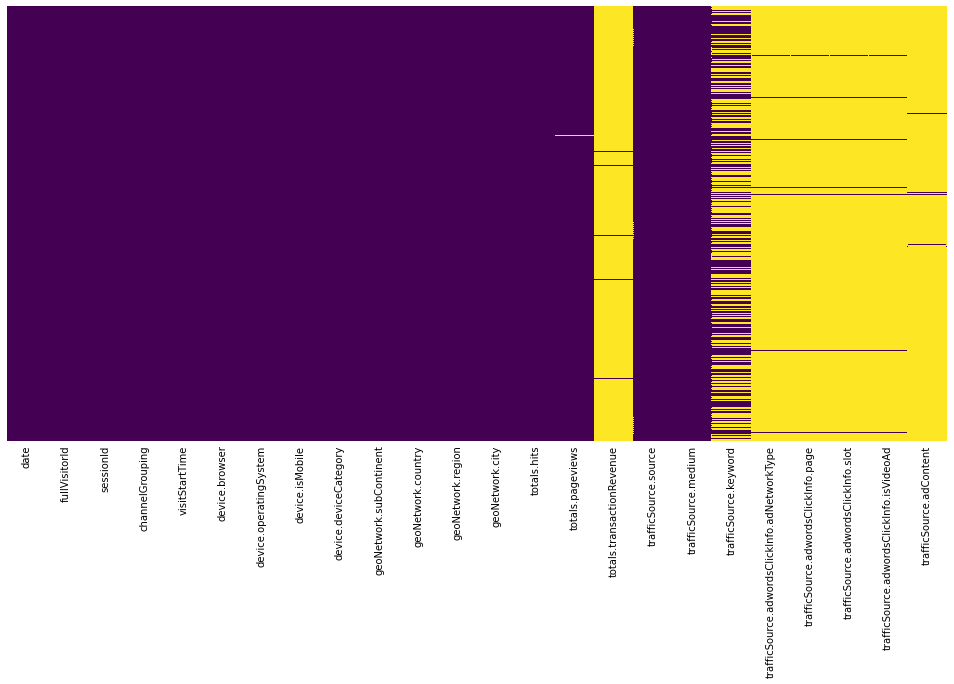

In [4]:
fig, ax = plt.subplots(figsize=(15,8))

sns_heatmap = sns.heatmap(df.sample(5000).isnull(), 
                          yticklabels=False, 
                          cbar=False, 
                          cmap='viridis')

Посмотрим на описательные статистики. 

In [5]:
df.describe()

,date,visitStartTime,totals.hits,totals.pageviews,totals.transactionRevenue,trafficSource.adwordsClickInfo.page
count,9.036530e+05,9.036530e+05,903653.000000,903553.000000,11515.000000,21460.000000
mean,2.016589e+07,1.485007e+09,4.596538,3.849764,133.744789,1.008108
std,4.697698e+03,9.022124e+06,9.641437,7.025274,448.285227,0.173584
min,2.016080e+07,1.470035e+09,1.000000,1.000000,0.010000,1.000000
25%,2.016103e+07,1.477561e+09,1.000000,1.000000,24.930000,1.000000
50%,2.017011e+07,1.483949e+09,2.000000,1.000000,49.450000,1.000000
75%,2.017042e+07,1.492759e+09,4.000000,4.000000,107.655000,1.000000
max,2.017080e+07,1.501657e+09,500.000000,469.000000,23129.500000,14.000000


In [6]:
df.describe(include='object')

,fullVisitorId,sessionId,channelGrouping,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.city,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent
count,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,400724,21460,21460,21460,10946
unique,731421,902755,8,54,20,3,23,222,376,649,380,7,3659,2,2,1,44
top,1957458976293878100,7331245265148942309_1474698220,Organic Search,Chrome,Windows,desktop,Northern America,United States,not available in demo dataset,not available in demo dataset,google,organic,(not provided),Google Search,Top,False,Google Merchandise Collection
freq,252,2,381561,620364,350072,664479,390657,364744,508229,508229,400788,381561,366363,21453,20956,21460,5122


Заведём несколько переменных со временем. 

In [7]:
df["date"].dtype

dtype('int64')

In [8]:
df['date'][:10]

0    20160902
1    20160902
2    20160902
3    20160902
4    20160902
5    20160902
6    20160902
7    20160902
8    20160902
9    20160902
Name: date, dtype: int64

In [9]:
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["date"][:10]

0   2016-09-02
1   2016-09-02
2   2016-09-02
3   2016-09-02
4   2016-09-02
5   2016-09-02
6   2016-09-02
7   2016-09-02
8   2016-09-02
9   2016-09-02
Name: date, dtype: datetime64[ns]

In [10]:
df['month'] = df['date'].apply(lambda w: w.strftime('%Y-%m'))
df['month'][:10]

0    2016-09
1    2016-09
2    2016-09
3    2016-09
4    2016-09
5    2016-09
6    2016-09
7    2016-09
8    2016-09
9    2016-09
Name: month, dtype: object

In [11]:
df["visitDay"] = df['date'].dt.day #Модуль `dt` - методы для работы со временем
df["visitDay"][:10]

0    2
1    2
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    2
Name: visitDay, dtype: int64

In [12]:
df["visitDay"] = df['date'].dt.day             # день визита
df["visitMonth"] = df['date'].dt.month         # месяц визита

df["visitWeekday"] = df['date'].dt.weekday     # выходные
df["visitWeeknum"] = df['date'].dt.weekofyear  # порядковый номер недели в году

# начало и конец месяца
df["is_month_start"] = df['date'].dt.is_month_start
df["is_month_end"] = df['date'].dt.is_month_end

In [13]:
df['visitStartTime'][:10]

0    1472830385
1    1472880147
2    1472865386
3    1472881213
4    1472822600
5    1472807194
6    1472817241
7    1472812602
8    1472805784
9    1472812272
Name: visitStartTime, dtype: int64

In [14]:
from datetime import datetime
datetime.fromtimestamp(1472812272).minute

31

In [15]:
# час визита
df['visitHour'] = (df['visitStartTime'].apply(
    lambda x: datetime.fromtimestamp(x).hour))

# время визита с точностью до секунды
df['ts'] = df['visitStartTime'].apply(lambda x: 
                                      pd.datetime.fromtimestamp(x))

<ipython-input-15-9ed2e6c96e91>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.fromtimestamp(x))


# 2. Возвращаемость и посещаемость

> Проанализируем что происходит с посещаемостью сайта и возвращаемостью пользователей. 

In [16]:
df.head()

,date,fullVisitorId,sessionId,channelGrouping,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.subContinent,...,trafficSource.adContent,month,visitDay,visitMonth,visitWeekday,visitWeeknum,is_month_start,is_month_end,visitHour,ts
0,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Organic Search,1472830385,Chrome,Windows,False,desktop,Western Asia,...,NaN,2016-09,2,9,4,35,False,False,18,2016-09-02 18:33:05
1,2016-09-02,377306020877927890,377306020877927890_1472880147,Organic Search,1472880147,Firefox,Macintosh,False,desktop,Australasia,...,NaN,2016-09,2,9,4,35,False,False,8,2016-09-03 08:22:27
2,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Organic Search,1472865386,Chrome,Windows,False,desktop,Southern Europe,...,NaN,2016-09,2,9,4,35,False,False,4,2016-09-03 04:16:26
3,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Organic Search,1472881213,UC Browser,Linux,False,desktop,Southeast Asia,...,NaN,2016-09,2,9,4,35,False,False,8,2016-09-03 08:40:13
4,2016-09-02,27294437909732085,27294437909732085_1472822600,Organic Search,1472822600,Chrome,Android,True,mobile,Northern Europe,...,NaN,2016-09,2,9,4,35,False,False,16,2016-09-02 16:23:20


## 2.1 Сколько людей пользуются магазином в день/месяц?

Посчитаем уникальное число пользователей для каждого дня.

In [17]:
df_day = (
    df.groupby('date')
    .agg({'fullVisitorId': 'nunique'})
    .sort_values('date')
)

df_day.head()

,fullVisitorId
date,
2016-08-01,1569
2016-08-02,1961
2016-08-03,2657
2016-08-04,2947
2016-08-05,2492


Среднее число посетителей в день: 2282.8169398907103


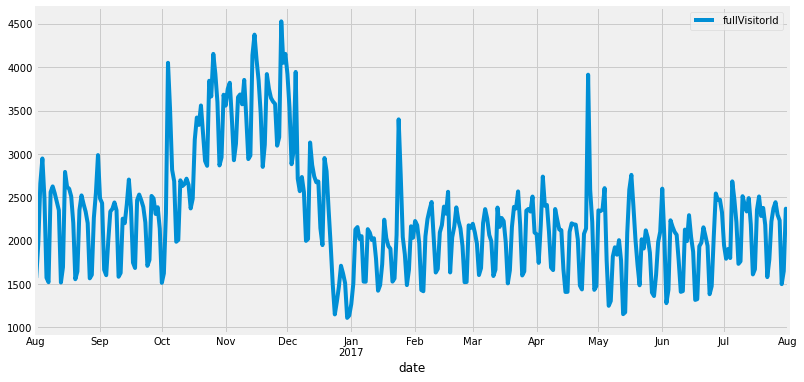

In [18]:
print(f"Среднее число посетителей в день: {df_day.fullVisitorId.mean()}")
df_day.plot(figsize=(12,6));

Среднее число посетителей в месяц: 58884.692307692305


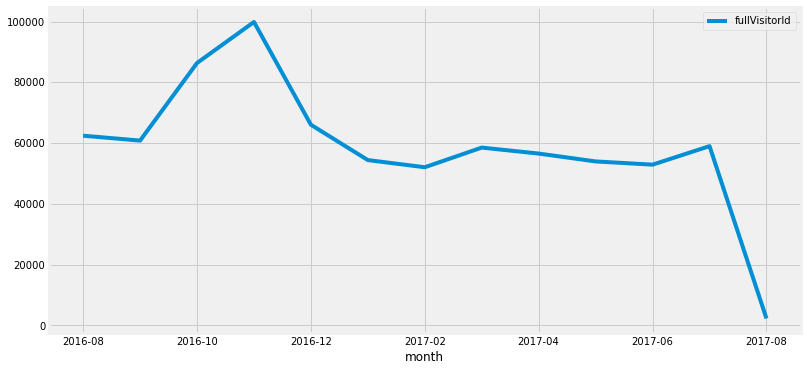

In [19]:
df_month = (
    df.groupby('month')
    .agg({'fullVisitorId': 'nunique'})
    .sort_values('month')
)

print(f"Среднее число посетителей в месяц: {df_month.fullVisitorId.mean()}")
df_month.plot(figsize=(12,6));

__Выводы:__ Основаня волна посещений магазина наблюдается осенью, летом идёт спад. На дневном графике чётко видна недельная сезонность. В выходные наблюдается спад пользовательской активности. 

## 2.2 Сколько пользовательских сессий в день? 

Для этого нам необходимо сгруппировать по дням посещения и посчитать кол-во пользователей, но не уникальных.

Среднее число сессий в день: 2468.997267759563


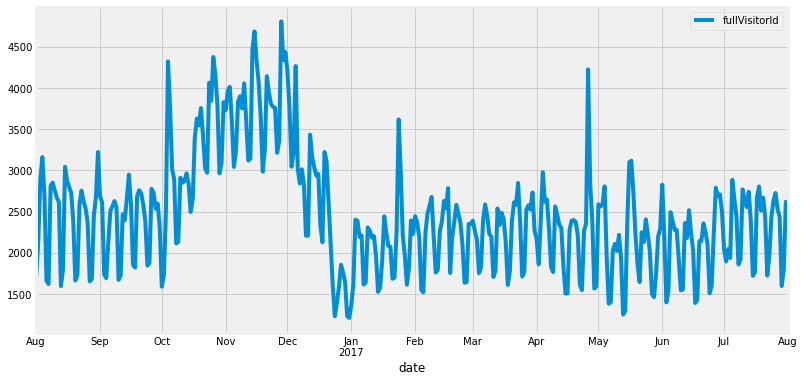

In [20]:
df_session = (
    df.groupby('date')
    .agg({'fullVisitorId': 'count'})
    .sort_values('date')
)

print(f"Среднее число сессий в день: {df_session.fullVisitorId.mean()}")
df_session.plot(figsize=(12,6));

Видим, что график не сильно отличается от динамики уникальных пользователей. Это позволяет предположить, то что возвращаются люди очень редко. Проверим это.

## 2.3 Как часто люди возвращаются? 

Чтобы ответить на этот вопрос воспользуемся когортным анализом, за когорту будем брать посетителей зарегистровавшихся в одном месяце.

In [21]:
first_month_session = (
    df.groupby('fullVisitorId')
    .agg({
        'month':'min',
        'date': 'min',
        'ts': 'min'
    })
)

first_month_session.columns = ['first_invate_month', 'first_invate_day', 'first_invate_ts']
first_month_session.head()

,first_invate_month,first_invate_day,first_invate_ts
fullVisitorId,,,
4823595352351,2016-11,2016-11-01,2016-11-01 17:45:10
5103959234087,2016-08,2016-08-21,2016-08-22 01:06:48
10278554503158,2016-10,2016-10-20,2016-10-21 08:57:46
20424342248747,2016-11,2016-11-30,2016-12-01 10:55:01
26722803385797,2017-06,2017-06-05,2017-06-05 13:26:34


In [22]:
df = df.merge(first_month_session, on='fullVisitorId')

kogort_month = df[['fullVisitorId', 'month', 'first_invate_month']]
kogort_month.head()

,fullVisitorId,month,first_invate_month
0,1131660440785968503,2016-09,2016-09
1,377306020877927890,2016-09,2016-09
2,3895546263509774583,2016-09,2016-09
3,4763447161404445595,2016-09,2016-09
4,27294437909732085,2016-09,2016-08


Выделили группы уникальных пользователей по месяцам, построим таблицу, которая покажет возврат пользователей на ресурс.

In [23]:
retention = kogort_month.pivot_table(
    index='first_invate_month',
    columns='month',
    values = 'fullVisitorId',
    aggfunc='nunique'
)

retention

month,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08
first_invate_month,,,,,,,,,,,,,
2016-08,62462.0,2204.0,1033.0,602.0,418.0,271.0,216.0,181.0,139.0,135.0,106.0,89.0,3.0
2016-09,NaN,58645.0,1936.0,699.0,371.0,212.0,135.0,112.0,111.0,77.0,55.0,52.0,1.0
2016-10,NaN,NaN,83411.0,2396.0,753.0,356.0,253.0,192.0,133.0,108.0,83.0,67.0,1.0
2016-11,NaN,NaN,NaN,96199.0,2425.0,620.0,295.0,230.0,168.0,126.0,88.0,78.0,NaN
2016-12,NaN,NaN,NaN,NaN,62098.0,1643.0,457.0,304.0,215.0,153.0,105.0,95.0,3.0
2017-01,NaN,NaN,NaN,NaN,NaN,51329.0,1469.0,494.0,275.0,167.0,118.0,89.0,3.0
2017-02,NaN,NaN,NaN,NaN,NaN,NaN,49248.0,1488.0,450.0,293.0,162.0,113.0,2.0
2017-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55542.0,1560.0,492.0,239.0,181.0,4.0
2017-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53525.0,1504.0,470.0,256.0,3.0


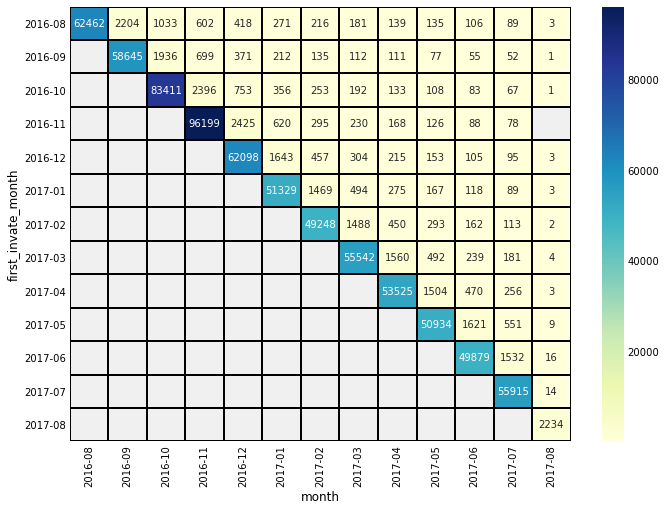

In [24]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    retention,
    annot=True,
    fmt='.0f',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu"
);

Перейдём к процентам.

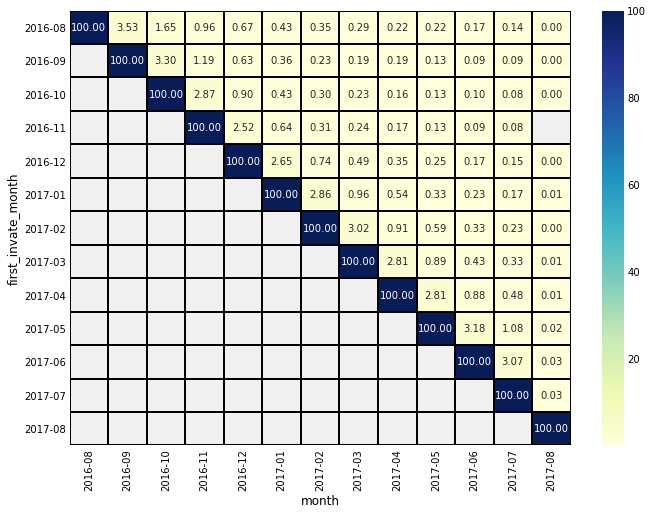

In [25]:
first_date = retention.values.diagonal()

for s,row in zip(first_date, retention):
    retention.loc[row] = 100*(retention.loc[row]/s)

plt.figure(figsize=(10, 8))
sns.heatmap(
    retention,
    annot=True,
    fmt='.2f',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu"
);

Возвраты пользователей крайне малы. Где-то 3% возвращается на второй месяц, а дальше возврат обваливатеся почти до нуля. 

Какая доля визитов относится к месяцу отличному от первого визита? 

In [26]:
(kogort_month.month != kogort_month.first_invate_month).mean()

0.06694383795549841

А доля дней? 

In [27]:
(df.date != df.first_invate_day).mean()

0.13861847412668357

Видим, что повторные визиты бывают довольно редко. 

# 3. Покупки

> Проанализируем покупки, которые делаются на сайте. 

## 3.1 Когда люди покупают? 

In [28]:
df['totals.transactionRevenue'].isnull().mean()

0.9872572768529513

In [29]:
# Процент покупок 
100*(1 - df['totals.transactionRevenue'].isnull().mean())

1.2742723147048718

Около 1% пришедших сделали покупку. Такова суровая реальность. 

In [30]:
df_buy = df.dropna(subset=['totals.transactionRevenue'])
df_buy.shape

(11515, 36)

Посморим на распределение выручки. 

Text(0.5, 0, 'Логарифм выручки')

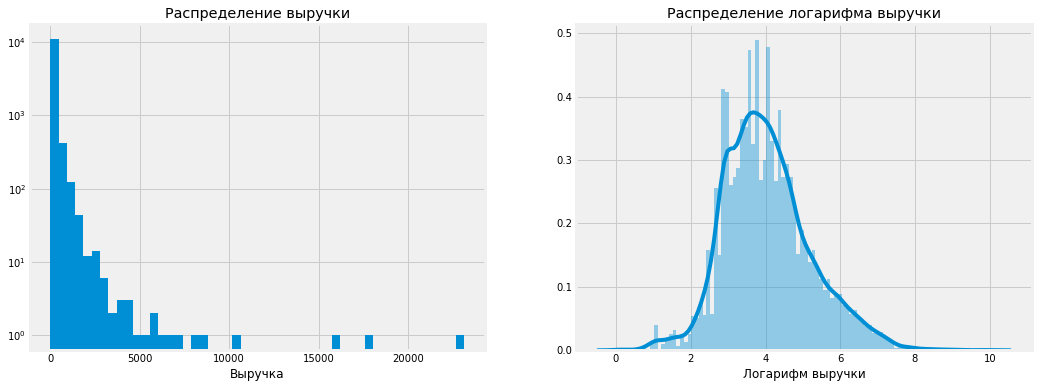

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

df_buy['totals.transactionRevenue'].hist(bins=50, log=True, ax=axes[0])
sns.distplot(
    np.log(df_buy['totals.transactionRevenue'] + 1), 
    ax=axes[1], 
    bins=100, 
    kde=True)

axes[0].set_title("Распределение выручки")
axes[0].set_xlabel("Выручка")

axes[1].set_title("Распределение логарифма выручки")
axes[1].set_xlabel("Логарифм выручки")


Посмотрим на дату первой покупки. Как часто она отличается от даты первого визита.

In [32]:
first_day_buy = (
    df_buy.groupby('fullVisitorId')
    .agg({
        'month':'min',
        'date': 'min',
        'ts': 'min'
    })
)

In [33]:
first_day_buy.head()

,month,date,ts
fullVisitorId,,,
213131142648941,2017-04,2017-04-28,2017-04-29 01:41:58
435324061339869,2016-10,2016-10-20,2016-10-21 04:33:41
562678147042735,2017-04,2017-04-24,2017-04-24 17:27:36
585708896049892,2016-12,2016-12-21,2016-12-21 23:59:44
670722016498267,2017-07,2017-07-10,2017-07-10 21:00:43


In [34]:
first_day_buy.columns = ['first_buy_month', 'first_buy_day', 'first_buy_ts']
first_day_buy.head()

,first_buy_month,first_buy_day,first_buy_ts
fullVisitorId,,,
213131142648941,2017-04,2017-04-28,2017-04-29 01:41:58
435324061339869,2016-10,2016-10-20,2016-10-21 04:33:41
562678147042735,2017-04,2017-04-24,2017-04-24 17:27:36
585708896049892,2016-12,2016-12-21,2016-12-21 23:59:44
670722016498267,2017-07,2017-07-10,2017-07-10 21:00:43


In [35]:
df_buy = df_buy.join(first_day_buy, on='fullVisitorId')
df_buy.head()

,date,fullVisitorId,sessionId,channelGrouping,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.subContinent,...,is_month_start,is_month_end,visitHour,ts,first_invate_month,first_invate_day,first_invate_ts,first_buy_month,first_buy_day,first_buy_ts
304,2016-10-23,5442500961218255804,5442500961218255804_1477276680,Referral,1477276680,Chrome,Chrome OS,False,desktop,Northern America,...,False,False,5,2016-10-24 05:38:00,2016-09,2016-09-02,2016-09-02 21:04:08,2016-10,2016-10-23,2016-10-24 05:38:00
393,2016-09-08,780206376162514125,0780206376162514125_1473373023,Referral,1473373023,Chrome,Macintosh,False,desktop,Northern America,...,False,False,1,2016-09-09 01:17:03,2016-09,2016-09-02,2016-09-03 00:04:36,2016-09,2016-09-08,2016-09-09 01:17:03
533,2016-11-23,8436426603099391262,8436426603099391262_1479954329,Referral,1479954329,Chrome,Macintosh,False,desktop,Northern America,...,False,False,5,2016-11-24 05:25:29,2016-08,2016-08-01,2016-08-01 18:16:59,2016-08,2016-08-06,2016-08-06 20:32:01
535,2016-09-01,8436426603099391262,8436426603099391262_1472781277,Referral,1472781277,Chrome,Macintosh,False,desktop,Northern America,...,True,False,4,2016-09-02 04:54:37,2016-08,2016-08-01,2016-08-01 18:16:59,2016-08,2016-08-06,2016-08-06 20:32:01
544,2016-11-04,8436426603099391262,8436426603099391262_1478265472,Referral,1478265472,Chrome,Macintosh,False,desktop,Northern America,...,False,False,16,2016-11-04 16:17:52,2016-08,2016-08-01,2016-08-01 18:16:59,2016-08,2016-08-06,2016-08-06 20:32:01


In [36]:
(df_buy.first_invate_day != df_buy.first_buy_day).mean()

0.34355188884064264

Сколько дней проходит от первого захода на сайт до первой покупки? 

In [37]:
(df_buy['first_buy_ts'] - df_buy['first_invate_ts']).head()

304   51 days 08:33:52
393    6 days 01:12:27
533    5 days 02:15:02
535    5 days 02:15:02
544    5 days 02:15:02
dtype: timedelta64[ns]

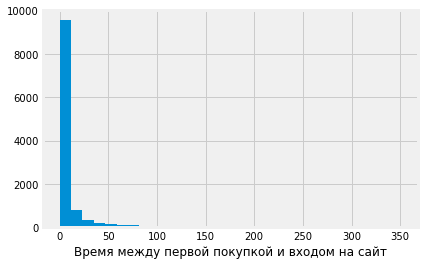

In [38]:
df_buy['deltatime_buy'] = (df_buy['first_buy_ts'] - df_buy['first_invate_ts'])/np.timedelta64(1,'D')

df_buy['deltatime_buy'].hist(bins=30)
plt.xlabel('Время между первой покупкой и входом на сайт');

In [39]:
df_buy['deltatime_buy'].describe()

count    11515.000000
mean         9.056645
std         28.007666
min          0.000000
25%          0.000000
50%          0.000000
75%          3.823142
max        351.061875
Name: deltatime_buy, dtype: float64

Выбросы сильно искажают среднее.

А часов? 

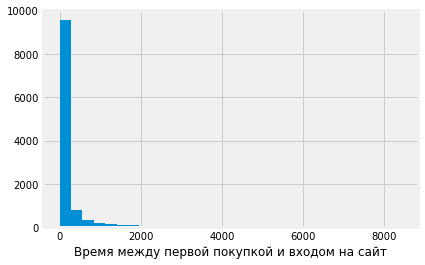

In [40]:
df_buy['deltatime_buy'] = (df_buy['first_buy_ts'] - df_buy['first_invate_ts'])/np.timedelta64(1,'h')
df_buy['deltatime_buy'].hist(bins=30)
plt.xlabel('Время между первой покупкой и входом на сайт');

In [41]:
df_buy['deltatime_buy'].describe()

count    11515.000000
mean       217.359469
std        672.183991
min          0.000000
25%          0.000000
50%          0.000000
75%         91.755417
max       8425.485000
Name: deltatime_buy, dtype: float64

In [42]:
df_buy['deltatime_buy'].quantile(0.6)

2.1727777777777777

Видим, что свою первую покупку пользователи совершают чаще всего в первый же визит. В $40\%$ случаев между визитом, когда была совершена покупка и первым визитом проходит больше 2 часов. Также мы видим, что хвост у распределения оказывается довольно большим. 

Посмотрим на динамику покупок. 

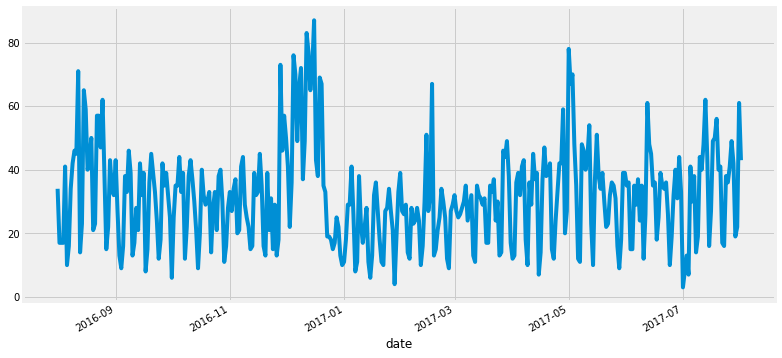

In [43]:
df_buy.groupby('date')['fullVisitorId'].count().plot(figsize=(12,6));

График покупок не отличается существенно от графика визитов в плане своей динамики. Посмотрим на то, как покупки распределены по дням недели и часам.  

In [44]:
df_buy.pivot_table(
    index = 'visitHour',
    columns = 'visitWeekday',
    values = 'totals.transactionRevenue',
    aggfunc='sum'
).style.background_gradient()

visitWeekday,0,1,2,3,4,5,6
visitHour,,,,,,,
0,17422.640000,14624.540000,25137.630000,22537.850000,15221.740000,3595.780000,5753.230000
1,21473.230000,16982.810000,13121.800000,14211.830000,14030.510000,5075.450000,5017.750000
2,11966.600000,12984.400000,10705.910000,13838.480000,8757.460000,5247.520000,3099.010000
3,7524.180000,10727.410000,11670.090000,8393.850000,10602.710000,2992.620000,8701.000000
4,16227.800000,9555.940000,6670.720000,8736.550000,7504.180000,2641.710000,4325.630000
5,7523.700000,8783.510000,14343.220000,7145.230000,6127.220000,1945.990000,4971.040000
6,5061.840000,8334.140000,6240.970000,6100.600000,4255.710000,4416.970000,2557.140000
7,7517.650000,6641.440000,6024.650000,4091.180000,3164.940000,2218.530000,4684.100000
8,3870.360000,6590.460000,4807.850000,3843.000000,1978.590000,1249.680000,2473.030000


C 17 до 23 часов видим самое большое число покупок. 

## 3.2  Сколько раз покупают за период?

Посчитаем статистику о покупках в разбиении по когортам. Когорта - месяц первой покупки.

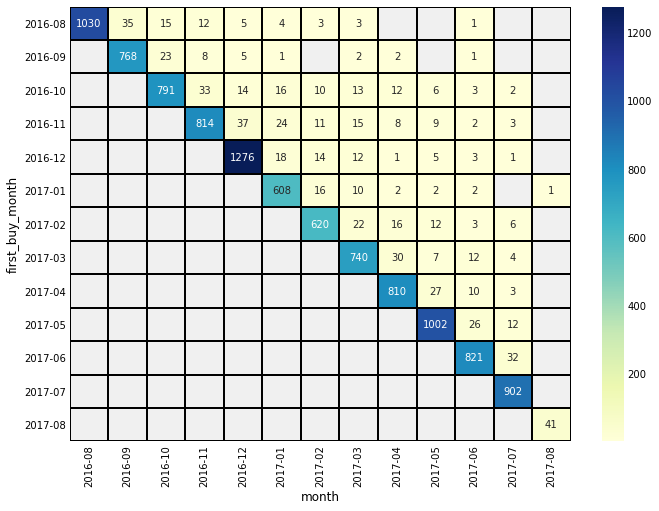

In [45]:
sales = df_buy.pivot_table(
    index='first_buy_month',
    columns='month',
    values = 'fullVisitorId',
    aggfunc='nunique'
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    sales,
    annot=True,
    fmt='.0f',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu"
);

Снова видим, что интерес к магазину падает уже на второй месяц. 

## 3.3  Средний доход

Посчитаем его на дневной основе. 

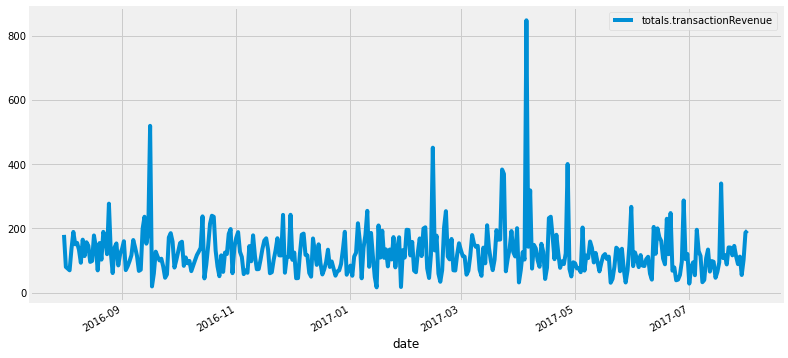

In [46]:
g = (
    df_buy.groupby('date')
    .agg({'totals.transactionRevenue':'mean'})
    .plot(figsize=(12,6))
)

Посчитаем сколько денег приносят в среднем отдельные когорты. Для этого посчитаем суммарную выручку с каждой и поделим на число пользователей в ней. 

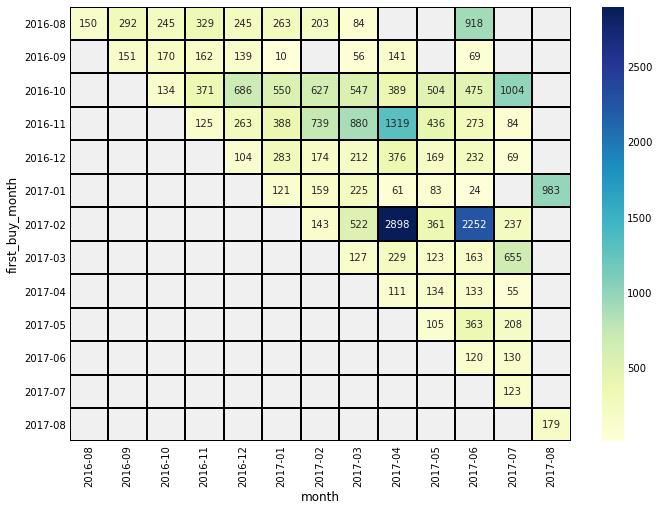

In [47]:
sales_sum = df_buy.pivot_table(
    index='first_buy_month',
    columns='month',
    values = 'totals.transactionRevenue',
    aggfunc='sum'
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    sales_sum/sales,
    annot=True,
    fmt='.0f',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu"
);

Есть несколько покупок на очень крупную сумму в февральской когорте.

# 4. Анализ выручки в разбивке по источникам

> Проанализируем выручку в разбивке по её источникам.

In [48]:
df_buy['totals.transactionRevenue'] = df_buy['totals.transactionRevenue'].apply(lambda w: np.log(w + 1))

Посмотрим какие браузеры самые популярные.

In [49]:
df_buy['device.browser'].value_counts()[:10]

Chrome               10353
Safari                 780
Firefox                191
Internet Explorer      109
Edge                    58
Safari (in-app)         12
Android Webview          6
Opera                    5
Amazon Silk              1
Name: device.browser, dtype: int64

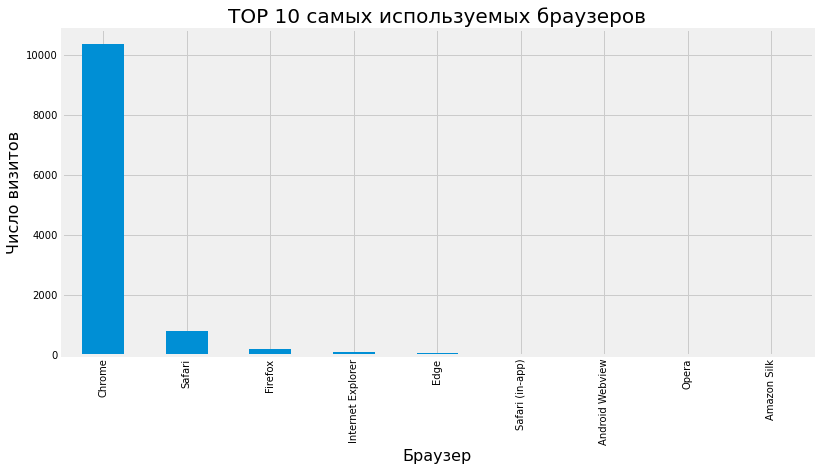

In [50]:
plt.figure(figsize=(12,6))

df_buy['device.browser'].value_counts().plot(kind='bar')

plt.title("TOP 10 самых используемых браузеров", fontsize=20)
plt.xlabel("Браузер", fontsize=16)
plt.ylabel("Число визитов", fontsize=16);

Выручка с разбивкой по браузерам

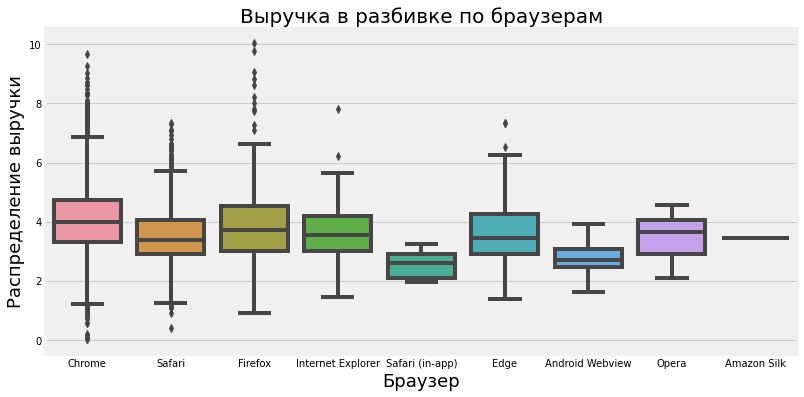

In [51]:
plt.figure(figsize=(12,6))

data = (df_buy[
    df_buy['device.browser'].isin(
        df_buy['device.browser'].value_counts()[:10].index.values
    )]
)

g = sns.boxplot(x='device.browser', 
              y='totals.transactionRevenue', 
              data=data);

g.set_title('Выручка в разбивке по браузерам', fontsize=20)
g.set_xlabel('Браузер', fontsize=18)
g.set_ylabel('Распределение выручки', fontsize=18);

Посмотрим на операционные системы. 

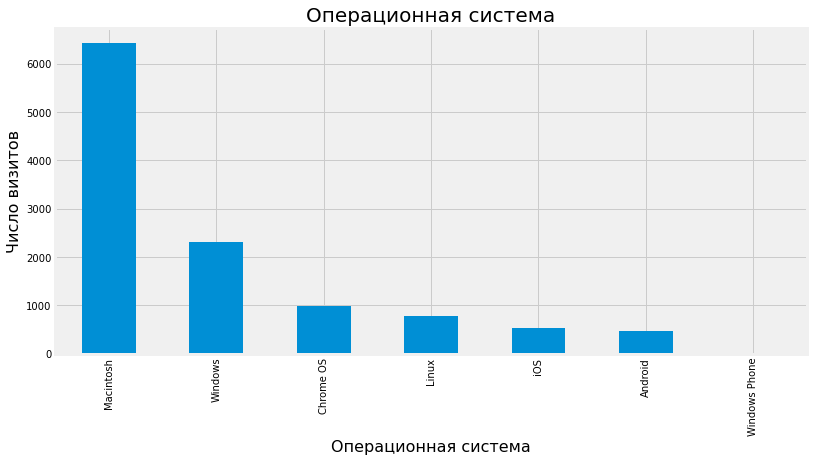

In [52]:
plt.figure(figsize=(12,6))

df_buy['device.operatingSystem'].value_counts().plot(kind='bar')

plt.title("Операционная система", fontsize=20)
plt.xlabel("Операционная система", fontsize=16)
plt.ylabel("Число визитов", fontsize=16);

Прибыль по разным операционным системам

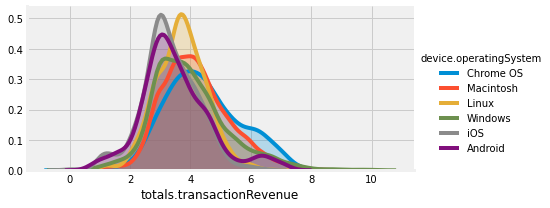

In [53]:
data = (
    df_buy[
        df_buy['device.operatingSystem']
       .isin(df_buy['device.operatingSystem'].value_counts()[:6].index.values)
          ]
)


# Такой же приём можно использовать и для графиков
g = ( 
    sns.FacetGrid(data, hue='device.operatingSystem', aspect=2)
    .map(sns.kdeplot, 'totals.transactionRevenue', shade=True)
    .add_legend()
);

Выручка в разбивке по разным типам устройств. 

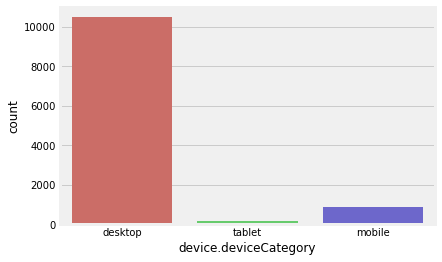

In [54]:
sns.countplot(df_buy["device.deviceCategory"], palette="hls");

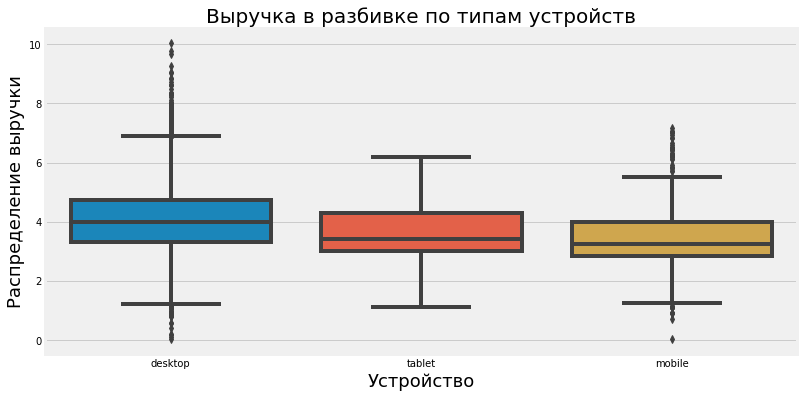

In [55]:
plt.figure(figsize=(12,6))

g = sns.boxplot(x='device.deviceCategory', 
              y='totals.transactionRevenue', 
              data=df_buy);

g.set_title('Выручка в разбивке по типам устройств', fontsize=20)
g.set_xlabel('Устройство', fontsize=18)
g.set_ylabel('Распределение выручки', fontsize=18);

_______

Эта работа не написана мной с нуля. В ее основе лежала разработка моего наставника (преподавателя курса ML for Marketing, Филиппа Ульянкина), с которым мы совместно искали ответы на поставленные вопросы. Но она - наглядная иллюстрация того, с какими запросами я могу работать и какие данные вытаскивать из датасетов для принятия маркетинговых и бизнес-решений.